In [189]:
#Price analysis to identify the price trends over the period

# We will perform analysis to identify the price trends over the period 
# and predict the optimum listing price for the selected period. 
# This price can be used by the host to maximize profit and increase the occupancy rate.

import pandas as pd
import matplotlib.pyplot as plt

In [190]:
calendarDetailDF=pd.read_csv("./airbnb-open-data-in-nyc/calendar_detail.csv")

In [191]:
calendarDetailDF.head()

,listing_id,date,available,price
0,2515,2018-10-01,t,$99.00
1,2515,2018-09-30,t,$89.00
2,2515,2018-09-29,t,$99.00
3,2515,2018-09-28,t,$99.00
4,2515,2018-09-27,t,$99.00


In [192]:
# Replace NaN with 0
calendarDetailDF.fillna(0, inplace=True)

# Drop rows with 0 price
calendarDetailDF = calendarDetailDF[calendarDetailDF.price != 0]

In [193]:
calendarDetailDF.head()

,listing_id,date,available,price
0,2515,2018-10-01,t,$99.00
1,2515,2018-09-30,t,$89.00
2,2515,2018-09-29,t,$99.00
3,2515,2018-09-28,t,$99.00
4,2515,2018-09-27,t,$99.00


In [194]:
# Remove $ and convert price to float
calendarDetailDF['price'] = calendarDetailDF['price'].replace('[\$,]', '', regex=True).astype(float)
calendarDetailDF.head()

,listing_id,date,available,price
0,2515,2018-10-01,t,99.0
1,2515,2018-09-30,t,89.0
2,2515,2018-09-29,t,99.0
3,2515,2018-09-28,t,99.0
4,2515,2018-09-27,t,99.0


In [195]:
#Split the date as year, month and day
calendarDetailDF['Year'], calendarDetailDF['Month'], calendarDetailDF['Date'] = calendarDetailDF['date'].str.split('-',2).str

#Add Day to every row
calendarDetailDF['date'] = pd.to_datetime(calendarDetailDF['date'], errors='coerce')
calendarDetailDF['Day'] = calendarDetailDF['date'].dt.weekday_name

calendarDetailDF.head()

,listing_id,date,available,price,Year,Month,Date,Day
0,2515,2018-10-01,t,99.0,2018,10,01,Monday
1,2515,2018-09-30,t,89.0,2018,09,30,Sunday
2,2515,2018-09-29,t,99.0,2018,09,29,Saturday
3,2515,2018-09-28,t,99.0,2018,09,28,Friday
4,2515,2018-09-27,t,99.0,2018,09,27,Thursday


In [198]:
# Assign Season to every entry
lookup = {
    '01': 'Winter',
    '02': 'Spring',
    '03': 'Spring',
    '04': 'Spring',
    '05': 'Summer',
    '06': 'Summer',
    '07': 'Summer',
    '08': 'Autumn',
    '09': 'Autumn',
    '10': 'Autumn',
    '11': 'Winter',
    '12': 'Winter'
}

calendarDetailDF['Season'] = calendarDetailDF['Month'].apply(lambda x: lookup[x])

calendarDetailDF.head()

,listing_id,date,available,price,Year,Month,Date,Day,Season
0,2515,2018-10-01,t,99.0,2018,10,01,Monday,Autumn
1,2515,2018-09-30,t,89.0,2018,09,30,Sunday,Autumn
2,2515,2018-09-29,t,99.0,2018,09,29,Saturday,Autumn
3,2515,2018-09-28,t,99.0,2018,09,28,Friday,Autumn
4,2515,2018-09-27,t,99.0,2018,09,27,Thursday,Autumn


In [199]:
# Average price by season
seasonDF = calendarDetailDF.groupby(['Season']).price.mean()
seasonDF = seasonDF.reset_index()
seasonDF = seasonDF.rename(columns={'price':'Average Price'})
seasonDF

,Season,Average Price
0,Autumn,175.868981
1,Spring,166.968919
2,Summer,175.794747
3,Winter,164.682278


In [200]:
# Average price by season and year
yearSeasonDF = calendarDetailDF.groupby(['Year', 'Season']).price.mean()
yearSeasonDF = yearSeasonDF.reset_index()
yearSeasonDF = yearSeasonDF.rename(columns={'price':'Average Price'})
yearSeasonDF['Year-Season'] = yearSeasonDF['Year'].map(str) + "/" + yearSeasonDF['Season'].map(str)
yearSeasonDF

,Year,Season,Average Price,Year-Season
0,2017,Autumn,177.907201,2017/Autumn
1,2017,Winter,166.790620,2017/Winter
2,2018,Autumn,175.301110,2018/Autumn
3,2018,Spring,166.968919,2018/Spring
4,2018,Summer,175.794747,2018/Summer
5,2018,Winter,160.693973,2018/Winter


In [201]:
# Average price by year and month
yearMonthDF = calendarDetailDF.groupby(['Year','Month']).price.mean()
yearMonthDF = yearMonthDF.reset_index()
yearMonthDF = yearMonthDF.rename(columns={'price':'Average Price'})
yearMonthDF['Month/Year'] = yearMonthDF['Month'].map(str) + "/" + yearMonthDF['Year'].map(str)
yearMonthDF

,Year,Month,Average Price,Month/Year
0,2017,10,177.907201,10/2017
1,2017,11,164.961332,11/2017
2,2017,12,168.393642,12/2017
3,2018,01,160.693973,01/2018
4,2018,02,160.583151,02/2018
5,2018,03,166.697515,03/2018
6,2018,04,174.978801,04/2018
7,2018,05,175.628840,05/2018
8,2018,06,175.936978,06/2018
9,2018,07,175.819912,07/2018


Text(0.5,0,'Average Price')

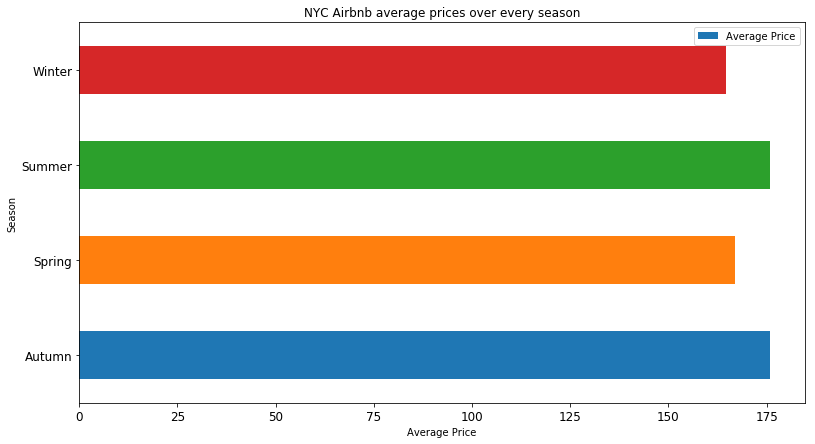

In [202]:
seasonDF.plot(x='Season', 
              y='Average Price', 
              kind='barh',
              figsize =(13,7),
              fontsize=12,
              title = "NYC Airbnb average prices over every season" 
             );

plt.xlabel('Average Price')

Text(0.5,0,'Average Price')

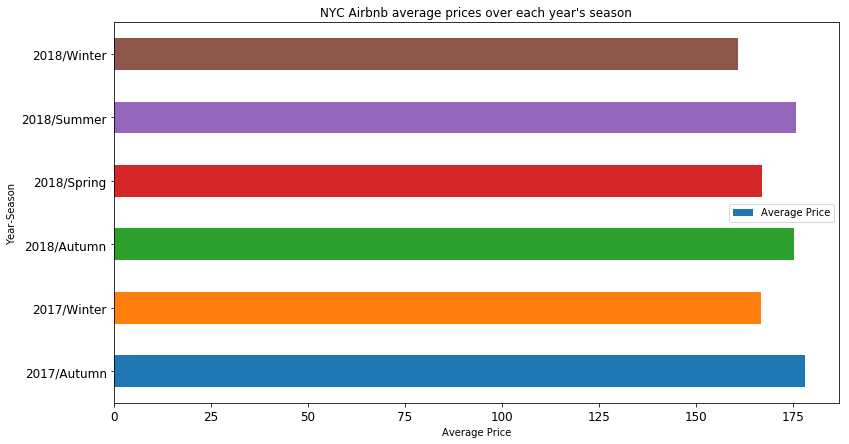

In [203]:
yearSeasonDF.plot(x='Year-Season', 
                  y='Average Price', 
                  kind='barh',
                  figsize =(13,7),
                  fontsize=12,
                  title = "NYC Airbnb average prices over each year's season" 
                 );

plt.xlabel('Average Price')

Text(0.5,0,'Average Price')

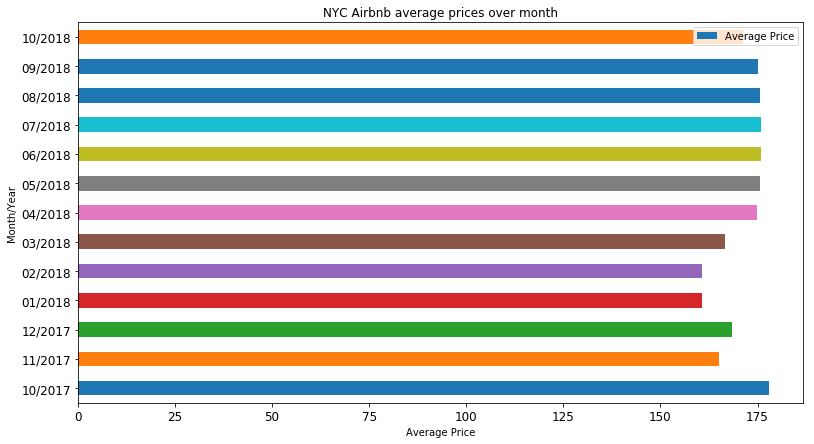

In [204]:
yearMonthDF.plot(x='Month/Year', 
                 y='Average Price', 
                 kind='barh', 
                 figsize =(13,7),
                 fontsize=12,
                 title = 'NYC Airbnb average prices over month', 
                );

plt.xlabel('Average Price')

In [210]:
dayDF = calendarDetailDF.groupby(['Day']).price.mean()
dayDF = dayDF.reset_index()
dayDF = dayDF.rename(columns={'price':'Average Price'})
dayDF

,Day,Average Price
0,Friday,174.693332
1,Monday,168.684574
2,Saturday,174.902118
3,Sunday,169.176612
4,Thursday,168.297459
5,Tuesday,168.373545
6,Wednesday,168.195359


Text(0.5,0,'Average Price')

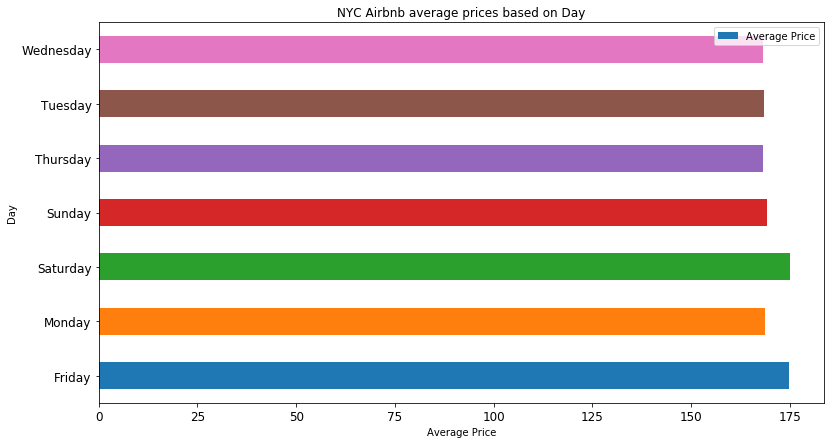

In [211]:
dayDF.plot(x='Day', 
           y='Average Price', 
           kind='barh', 
           figsize =(13,7),
           fontsize=12,
           title = 'NYC Airbnb average prices based on Day'
          );

plt.xlabel('Average Price')